# Cancer Dataset analysis

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.5.0'

In [3]:
from tensorflow import keras

In [4]:
keras.__version__

'2.5.0'

In [5]:
import tensorflow.keras.backend as K

In [6]:
from tensorflow.keras import backend

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## For plotting
import plotly.express as px
import plotly.graph_objects as go
import plotly.tools

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [9]:
np.random.seed(2021)

In [10]:
#from google.colab import files
#uploaded = files.upload()

In [11]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
#from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras.preprocessing.image import save_img as imsave

#from IPython.display import image
from PIL import Image

In [12]:
#import neccessary Libraries and modules

import os
from glob import glob
import random
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D

import warnings
warnings.filterwarnings('ignore')

In [13]:
imagePatches = glob('./breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2251_y751_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1901_y401_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3201_y1101_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3351_y1251_class0.png
./breast-histopathology-images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2051_y2551_class0.png


In [14]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [15]:
len(class0)

198738

In [16]:
len(class1)

78786

In [53]:
sampled_class0 = random.sample(class0, 8786)
sampled_class1 = random.sample(class1, 8786)


In [41]:
from matplotlib.image import imread
import cv2_tools
import cv2

In [42]:
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            #img = imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [54]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [23]:
from keras.preprocessing.image import load_img, img_to_array

In [24]:
def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 25)
    i=0
    for loc in ind:
        plt.subplot(5,5,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

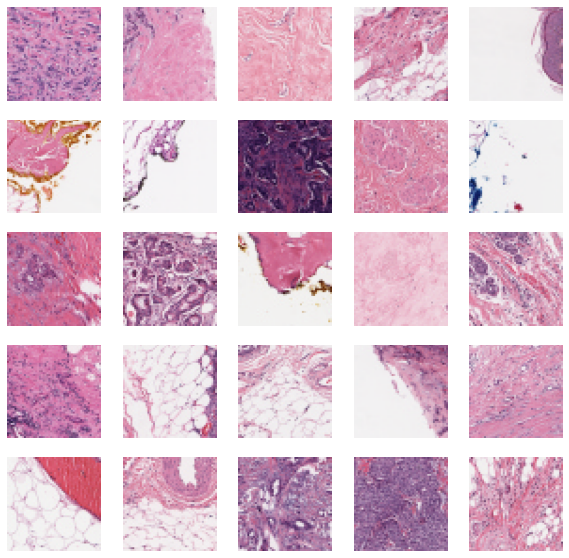

In [25]:
show_img(imagePatches)

In [55]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(2021)
random.shuffle(combined_data)

In [56]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [57]:
X = np.array(X).reshape(-1, 50, 50, 3)

In [58]:
X.shape

(17572, 50, 50, 3)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=2021)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12300, 50, 50, 3) (5272, 50, 50, 3) (12300, 2) (5272, 2)


In [77]:
y_test[:,1]

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [60]:
def create_model():        
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(50,50,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    #binary_crossentropy is used as Cancer detecion is  binary classification model
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   

    return model

In [63]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = create_model()
#Training and Testing the CNN 
#epochs determines no of times learning algorithm walks through the dataset
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 12,
    verbose = 1,
)

Epoch 1/12
385/385 [==============================] - 51s 133ms/step - loss: 1.7672 - accuracy: 0.8480 - val_loss: 0.4675 - val_accuracy: 0.8532
Epoch 2/12
385/385 [==============================] - 56s 145ms/step - loss: 0.3161 - accuracy: 0.8878 - val_loss: 0.4275 - val_accuracy: 0.8594
Epoch 3/12
385/385 [==============================] - 55s 144ms/step - loss: 0.2320 - accuracy: 0.9204 - val_loss: 0.3323 - val_accuracy: 0.8883
Epoch 4/12
385/385 [==============================] - 58s 152ms/step - loss: 0.1741 - accuracy: 0.9418 - val_loss: 0.3252 - val_accuracy: 0.8957
Epoch 5/12
385/385 [==============================] - 56s 145ms/step - loss: 0.1443 - accuracy: 0.9521 - val_loss: 0.3397 - val_accuracy: 0.8913
Epoch 6/12
385/385 [==============================] - 60s 155ms/step - loss: 0.1056 - accuracy: 0.9674 - val_loss: 0.3283 - val_accuracy: 0.9038
Epoch 7/12
385/385 [==============================] - 57s 147ms/step - loss: 0.0759 - accuracy: 0.9766 - val_loss: 0.3670 - val_ac

In [80]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 32)        18464     
_________________________________________________________________
flatten_4 (Flatten)          (None, 67712)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 135426    
Total params: 155,682
Trainable params: 155,682
Non-trainable params: 0
_________________________________________________________________


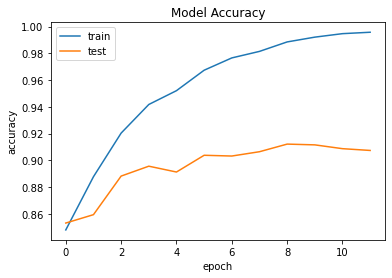

In [64]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

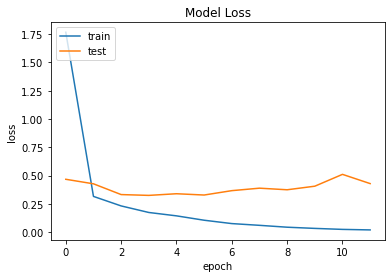

In [65]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
#Testing The CNN Model
pred = model.predict_proba(X_test)

In [73]:
pred[:,1]

array([9.8204656e-17, 1.9043236e-15, 3.8914878e-11, ..., 2.8304935e-01,
       7.6464820e-03, 1.9534725e-16], dtype=float32)

In [74]:
res = []
for prediction in pred[:,1]:
    if(prediction > 0.51):
        res.append(1)
    else:
        res.append(0)

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
#Final Classification Report using Confusion Matrix
print(confusion_matrix(y_test[:,1], res))
print(classification_report(y_test[:,1], res))

[[4301  169]
 [ 320  482]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      4470
         1.0       0.74      0.60      0.66       802

    accuracy                           0.91      5272
   macro avg       0.84      0.78      0.80      5272
weighted avg       0.90      0.91      0.90      5272



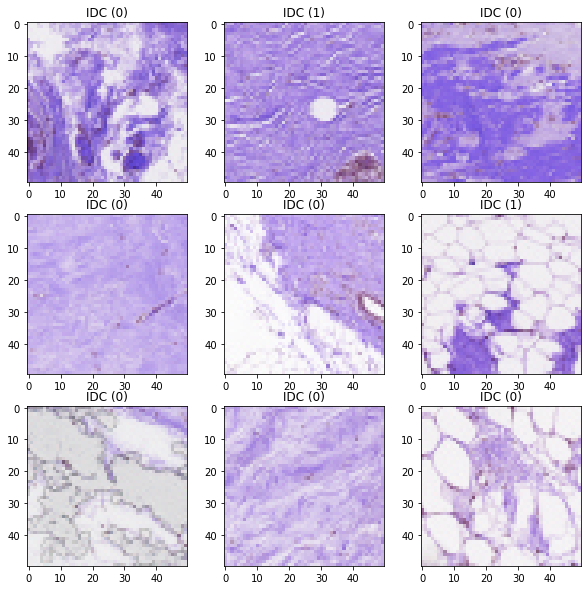

In [79]:
plt.figure(figsize= (11,11))
ind = np.random.randint(0, len(pred), 9)
i=0
#The patient having IDC is represented by IDC 1 ,IDC 0 otherwise.
for loc in ind:
    plt.subplot(3,3,i+1)
    plt.xlabel(None)
    plt.title("IDC ({})".format(res[loc]))
        
    plt.imshow(X_test[loc])
    i+=1